# Notebook 03: LLM Evaluation (Zero-Shot)

## Ziel dieses Notebooks

1. **LLMs laden** - 7-8B Parameter Modelle
2. **Zero-Shot Evaluation** - Ohne Training direkt testen
3. **ICD-10 Codes vorhersagen** - Aus Test-Dialogen
4. **Metriken berechnen** - Accuracy, F1, Precision, Recall
5. **Baseline speichern** - Für Vergleich mit finetuned SLMs

---

## Theoretischer Hintergrund

### Was ist Zero-Shot Inference?

Bei **Zero-Shot** testet man ein Modell direkt ohne vorheriges Training auf der Zielaufgabe. Das Modell nutzt nur sein Vorwissen aus dem Pre-Training.

### Warum LLMs als Baseline?

- **Hypothese**: "Größe = Wissen" - Größere Modelle sollten mehr können
- **Fairness**: Wir vergleichen unter gleichen Bedingungen (kein Finetuning)
- **Benchmark**: Wie gut ist "out-of-the-box" Performance?

### Unsere LLM-Modelle

| Modell | Größe | Beschreibung |
|--------|-------|--------------|
| Meta-Llama-3.1-8B-Instruct | 8B | Llama 3.1 Instruct-Version |
| Mistral-7B-Instruct-v0.3 | 7B | Mistral Instruct-Version |

---

In [1]:
# ============================================================
# SETUP: Imports und Umgebung
# ============================================================

import os
import gc
import re
import json
import time
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Union
from datetime import datetime

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
from datasets import load_dataset, Dataset, DatasetDict, load_from_disk
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sklearn.metrics import precision_recall_fscore_support

print("Imports erfolgreich!")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA verfügbar: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Imports erfolgreich!
   PyTorch: 2.10.0+cu128
   CUDA verfügbar: True
   GPU: NVIDIA GeForce RTX 5090
   VRAM: 33.6 GB


In [2]:
# ============================================================
# KONFIGURATION (Standalone)
# ============================================================

@dataclass
class PathConfig:
    project_root: Path = field(default_factory=lambda: Path.cwd().parent)
    data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data")
    cache_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "cache")
    processed_data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "processed")
    outputs_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs")
    plots_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "plots")
    reports_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "reports")
    predictions_cache_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "cache" / "predictions")
    
    def create_directories(self):
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Path) and not attr_name.startswith('_'):
                attr.mkdir(parents=True, exist_ok=True)

@dataclass
class DataConfig:
    dataset_name: str = "Ahmad0067/MedSynth"
    dataset_split_seed: int = 42
    train_ratio: float = 0.70
    val_ratio: float = 0.15
    test_ratio: float = 0.15
    max_sequence_length: int = 512

@dataclass  
class ModelConfig:
    """LLM Modelle für Zero-Shot Evaluation."""
    llm_models: List[Dict] = field(default_factory=lambda: [
        {
            "name": "meta-llama/Meta-Llama-3.1-8B-Instruct",
            "size": "8B",
            "description": "8B - Large reference model",
            "load_in_4bit": False,
        },
        {
            "name": "mistralai/Mistral-7B-Instruct-v0.3",
            "size": "7B", 
            "description": "7B - Medium reference model",
            "load_in_4bit": False,
        },
    ])

@dataclass
class EvaluationConfig:
    eval_batch_size: int = 32
    max_new_tokens: int = 50
    temperature: float = 0.1
    do_sample: bool = False

@dataclass
class Config:
    paths: PathConfig = field(default_factory=PathConfig)
    data: DataConfig = field(default_factory=DataConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    evaluation: EvaluationConfig = field(default_factory=EvaluationConfig)
    
    def setup(self):
        self.paths.create_directories()
        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

config = Config()
config.setup()

print("Konfiguration geladen!")
print(f"   LLM Modelle: {len(config.model.llm_models)}")
for m in config.model.llm_models:
    print(f"      - {m['name']} ({m['size']})")

Konfiguration geladen!
   LLM Modelle: 2
      - meta-llama/Meta-Llama-3.1-8B-Instruct (8B)
      - mistralai/Mistral-7B-Instruct-v0.3 (7B)


## 1. Utility-Funktionen

In [ ]:
# ============================================================
# UTILITY-FUNKTIONEN (Standalone)
# ============================================================

def get_device() -> str:
    """Bestimmt das beste verfügbare Device."""
    if torch.cuda.is_available():
        return "cuda"
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return "mps"
    return "cpu"

def aggressive_memory_cleanup():
    """Aggressive Memory-Cleanup."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        torch.cuda.ipc_collect()

def log_gpu_memory(prefix: str = ""):
    """Loggt GPU Memory Status."""
    if not torch.cuda.is_available():
        return
    allocated = torch.cuda.memory_allocated() / 1e9
    reserved = torch.cuda.memory_reserved() / 1e9
    msg = f"GPU: {allocated:.2f}GB alloc, {reserved:.2f}GB reserved"
    if prefix:
        msg = f"{prefix} - {msg}"
    print(msg)

def extract_icd_code(generated_text: str) -> str:
    """
    Extrahiert ICD-10 Code aus generiertem Text.
    
    Unterstützt beide Formate:
    - Standard ICD-10: A12.34, J06.9, M25.562 (mit Punkt)
    - MedSynth Format: A1234, J069, M25562 (ohne Punkt)
    
    Gibt immer das Format OHNE Punkt zurück für konsistente Vergleiche.
    """
    import re
    
    text = generated_text.strip().upper()
    
    # Pattern 1: Standard ICD-10 mit Punkt (z.B. H60.9, M25.562, J06.9)
    pattern_with_dot = r"\b([A-Z]\d{2})\.(\d{1,4})\b"
    matches = re.findall(pattern_with_dot, text)
    if matches:
        # Kombiniere ohne Punkt: H60.9 -> H609
        return matches[0][0] + matches[0][1]
    
    # Pattern 2: MedSynth Format ohne Punkt (z.B. H609, M25562, B9562)
    pattern_no_dot = r"\b([A-Z]\d{2,6})\b"
    matches = re.findall(pattern_no_dot, text)
    if matches:
        return matches[0]
    
    # Pattern 3: Nur Hauptkategorie (z.B. A12, J06)
    pattern_short = r"\b([A-Z]\d{2})\b"
    matches = re.findall(pattern_short, text)
    if matches:
        return matches[0]
    
    # Fallback: Erste Zeile, bereinigt
    lines = text.split("\n")
    if lines:
        first_line = lines[0].strip()
        return first_line.replace(".", "")[:10]
    
    return text.replace(".", "")[:10]

print("Utility-Funktionen definiert!")
print(f"   Device: {get_device()}")

## 2. LLM Model Wrapper

In [4]:
# ============================================================
# LLM MODEL WRAPPER (Standalone)
# ============================================================

class LLMModel:
    """
    Wrapper für Large Language Models.
    
    Unterstützt:
    - 4-bit/8-bit Quantisierung (BitsAndBytes)
    - Batch Prediction
    - Memory Management
    """
    
    def __init__(
        self,
        model_name: str,
        device: str = "cuda",
        load_in_4bit: bool = False,
        load_in_8bit: bool = False,
    ):
        """
        Args:
            model_name: HuggingFace Modell-ID
            device: Target device
            load_in_4bit: 4-bit Quantisierung
            load_in_8bit: 8-bit Quantisierung
        """
        self.model_name = model_name
        self.device = device
        self.load_in_4bit = load_in_4bit
        self.load_in_8bit = load_in_8bit
        self.model = None
        self.tokenizer = None
        self.is_loaded = False
    
    def load(self):
        """Lädt Modell und Tokenizer."""
        print(f"Lade LLM: {self.model_name}")
        
        # Quantisierungs-Konfiguration
        quantization_config = None
        if self.load_in_4bit or self.load_in_8bit:
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=self.load_in_4bit,
                load_in_8bit=self.load_in_8bit,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
            )
        
        # Tokenizer laden
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.tokenizer.padding_side = "left"
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Modell laden
        model_kwargs = {
            "device_map": "auto",
            "torch_dtype": torch.float16,
        }
        if quantization_config:
            model_kwargs["quantization_config"] = quantization_config
        
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name, 
            **model_kwargs
        )
        self.model.eval()
        self.is_loaded = True
        
        print(f"Modell geladen!")
        log_gpu_memory("Nach Laden")
    
    def predict(
        self,
        input_text: Union[str, List[str]],
        max_new_tokens: int = 50,
        temperature: float = 0.1,
        do_sample: bool = False,
        **kwargs
    ) -> Union[str, List[str]]:
        """Generiert Prediction(s)."""
        if not self.is_loaded:
            raise ValueError("Modell nicht geladen!")
        
        is_single = isinstance(input_text, str)
        texts = [input_text] if is_single else input_text
        
        inputs = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=2048
        ).to(self.model.device)
        
        gen_kwargs = {
            "max_new_tokens": max_new_tokens,
            "do_sample": do_sample,
            "pad_token_id": self.tokenizer.pad_token_id,
            "eos_token_id": self.tokenizer.eos_token_id,
        }
        
        if do_sample:
            gen_kwargs["temperature"] = temperature
        
        with torch.no_grad():
            outputs = self.model.generate(**inputs, **gen_kwargs)
        
        # Nur neue Tokens dekodieren
        input_length = inputs["input_ids"].shape[1]
        generated_tokens = outputs[:, input_length:]
        
        decoded = self.tokenizer.batch_decode(
            generated_tokens, 
            skip_special_tokens=True
        )
        
        return decoded[0] if is_single else decoded
    
    def predict_batch(
        self,
        input_texts: List[str],
        batch_size: int = 8,
        show_progress: bool = True,
        **kwargs
    ) -> List[str]:
        """Batched Prediction."""
        if not self.is_loaded:
            raise ValueError("Modell nicht geladen!")
        
        all_predictions = []
        n_batches = (len(input_texts) + batch_size - 1) // batch_size
        
        iterator = range(0, len(input_texts), batch_size)
        if show_progress:
            iterator = tqdm(iterator, total=n_batches, desc="Generiere Predictions")
        
        for i in iterator:
            batch = input_texts[i:i + batch_size]
            predictions = self.predict(batch, **kwargs)
            if isinstance(predictions, str):
                predictions = [predictions]
            all_predictions.extend(predictions)
        
        return all_predictions
    
    def unload(self):
        """Entlädt Modell aus Memory."""
        if self.model is not None:
            del self.model
            self.model = None
        if self.tokenizer is not None:
            del self.tokenizer
            self.tokenizer = None
        
        aggressive_memory_cleanup()
        self.is_loaded = False
        print(f"Modell entladen")
        log_gpu_memory("Nach Entladen")

print("LLMModel-Klasse definiert!")

LLMModel-Klasse definiert!


## 3. Medical Dialog Processor

In [5]:
# ============================================================
# MEDICAL DIALOG PROCESSOR (Standalone - für Inference)
# ============================================================

class MedicalDialogProcessor:
    """Formatiert Dialoge für Inference."""
    
    SYSTEM_PROMPT = """You are a medical assistance system that supports doctors in making diagnoses. 
Your task is to suggest the appropriate ICD-10 diagnosis code based on a doctor-patient dialogue.
Respond only with the ICD-10 code, without further explanation."""
    
    def __init__(self, tokenizer=None):
        self.tokenizer = tokenizer
    
    def format_dialog_for_inference(self, conversation: str) -> str:
        """Formatiert Dialog für Inference."""
        user_prompt = f"""Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

{conversation}

ICD-10 Code:"""
        
        # Chat-Template wenn verfügbar
        if self.tokenizer and hasattr(self.tokenizer, 'chat_template') and self.tokenizer.chat_template:
            messages = [
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt},
            ]
            try:
                return self.tokenizer.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=True
                )
            except:
                pass
        
        return f"System: {self.SYSTEM_PROMPT}\n\nUser: {user_prompt}\n\nAssistant:"

print("MedicalDialogProcessor definiert!")

MedicalDialogProcessor definiert!


## 4. Evaluator-Klasse

In [ ]:
# ============================================================
# MEDICAL DIAGNOSIS EVALUATOR (Standalone)
# ============================================================

class MedicalDiagnosisEvaluator:
    """
    Evaluator für ICD-10 Code Predictions.
    
    Metriken:
    - Exact Match Accuracy
    - Prefix Match (für hierarchische Codes)
    - Precision, Recall, F1
    """
    
    def __init__(self):
        self.predictions = []
        self.references = []
    
    def _normalize_icd_code(self, code: str) -> str:
        """
        Normalisiert ICD-10 Code für fairen Vergleich.
        
        - Entfernt Punkte (H60.9 -> H609)
        - Entfernt Whitespace
        - Uppercase
        """
        if not code:
            return ""
        return code.replace(".", "").strip().upper()
    
    def add_batch(self, predictions: List[str], references: List[str]):
        """Fügt Batch von Predictions hinzu."""
        self.predictions.extend(predictions)
        self.references.extend(references)
    
    def compute_exact_match_accuracy(self) -> float:
        """Exact Match Accuracy mit normalisiertem Vergleich."""
        if not self.predictions:
            return 0.0
        matches = sum(
            1 for p, r in zip(self.predictions, self.references)
            if self._normalize_icd_code(p) == self._normalize_icd_code(r)
        )
        return matches / len(self.predictions)
    
    def compute_prefix_match_accuracy(self, prefix_length: int = 3) -> float:
        """Prefix Match Accuracy (für ICD-10 Hierarchie) mit normalisierten Codes."""
        if not self.predictions:
            return 0.0
        
        matches = sum(
            1 for p, r in zip(self.predictions, self.references)
            if self._normalize_icd_code(p)[:prefix_length] == self._normalize_icd_code(r)[:prefix_length]
        )
        return matches / len(self.predictions)
    
    def compute_classification_metrics(self) -> Dict:
        """Precision, Recall, F1 mit normalisierten Codes."""
        if not self.predictions:
            return {}
        
        # Normalisiere beide Listen
        normalized_preds = [self._normalize_icd_code(p) for p in self.predictions]
        normalized_refs = [self._normalize_icd_code(r) for r in self.references]
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            normalized_refs, normalized_preds, 
            average="weighted", zero_division=0
        )
        
        return {
            "precision": float(precision),
            "recall": float(recall), 
            "f1": float(f1)
        }
    
    def compute_all_metrics(self) -> Dict:
        """Berechnet alle Metriken."""
        metrics = {
            "n_samples": len(self.predictions),
            "exact_match_accuracy": self.compute_exact_match_accuracy(),
            "prefix_match_3": self.compute_prefix_match_accuracy(3),
            "prefix_match_1": self.compute_prefix_match_accuracy(1),
        }
        metrics.update(self.compute_classification_metrics())
        return metrics
    
    def reset(self):
        """Setzt Evaluator zurück."""
        self.predictions = []
        self.references = []

print("MedicalDiagnosisEvaluator definiert!")

## 5. Test-Daten laden

In [7]:
# ============================================================
# TEST-DATEN LADEN
# ============================================================

# Versuche gespeicherte Daten zu laden
test_path = config.paths.processed_data_dir / "test_raw"

if test_path.exists():
    print(f"Lade gespeicherte Test-Daten: {test_path}")
    test_data = load_from_disk(str(test_path))
else:
    print(f"Lade Dataset von HuggingFace...")
    dataset = load_dataset(config.data.dataset_name, cache_dir=str(config.paths.cache_dir))
    
    if isinstance(dataset, DatasetDict):
        dataset = dataset["train"] if "train" in dataset else dataset[list(dataset.keys())[0]]
    
    # Split
    train_test = dataset.train_test_split(test_size=0.30, seed=config.data.dataset_split_seed)
    val_test = train_test["test"].train_test_split(test_size=0.50, seed=config.data.dataset_split_seed)
    test_data = val_test["test"]

# Identifiziere Felder
dialog_field = 'Dialogue' if 'Dialogue' in test_data.features else 'dialogue'
icd_field = 'ICD10' if 'ICD10' in test_data.features else 'icd10'

print(f"Test-Daten geladen: {len(test_data):,} Samples")
print(f"   Dialog-Feld: {dialog_field}")
print(f"   ICD-Feld: {icd_field}")

Lade gespeicherte Test-Daten: /home/bmw/src/simon/finetuning/data/processed/test_raw
Test-Daten geladen: 1,024 Samples
   Dialog-Feld: Dialogue
   ICD-Feld: ICD10


## 6. LLM Evaluation durchführen

In [8]:
# ============================================================
# EVALUATION-FUNKTION
# ============================================================

def evaluate_llm(
    model_config: Dict,
    test_data: Dataset,
    config: Config,
    max_samples: Optional[int] = None
) -> Dict:
    """
    Evaluiert ein LLM auf dem Test-Datensatz.
    
    Args:
        model_config: Modell-Konfiguration
        test_data: Test-Datensatz
        config: Haupt-Konfiguration
        max_samples: Optionale Begrenzung
    
    Returns:
        Dict mit Metriken
    """
    model_name = model_config["name"]
    model_short = model_name.split("/")[-1]
    
    print(f"\n{'='*60}")
    print(f"Evaluiere: {model_short} ({model_config['size']})")
    print(f"{'='*60}")
    
    # Modell laden
    llm = LLMModel(
        model_name=model_name,
        device=get_device(),
        load_in_4bit=model_config.get("load_in_4bit", True),
        load_in_8bit=model_config.get("load_in_8bit", False),
    )
    llm.load()
    
    # Processor erstellen
    processor = MedicalDialogProcessor(tokenizer=llm.tokenizer)
    
    # Daten vorbereiten
    if max_samples:
        eval_data = test_data.select(range(min(max_samples, len(test_data))))
    else:
        eval_data = test_data
    
    conversations = [sample[dialog_field] for sample in eval_data]
    references = [sample[icd_field] for sample in eval_data]
    
    # Prompts formatieren
    prompts = [processor.format_dialog_for_inference(conv) for conv in conversations]
    
    print(f"   Samples: {len(prompts)}")
    
    # Predictions generieren
    start_time = time.time()
    
    predictions_raw = llm.predict_batch(
        prompts,
        batch_size=config.evaluation.eval_batch_size,
        max_new_tokens=config.evaluation.max_new_tokens,
        temperature=config.evaluation.temperature,
        do_sample=config.evaluation.do_sample,
    )
    
    eval_time = time.time() - start_time
    
    # ICD-Codes extrahieren
    predictions = [extract_icd_code(pred) for pred in predictions_raw]
    
    # Metriken berechnen
    evaluator = MedicalDiagnosisEvaluator()
    evaluator.add_batch(predictions, references)
    metrics = evaluator.compute_all_metrics()
    
    # Zusätzliche Infos
    metrics["model_name"] = model_name
    metrics["model_size"] = model_config["size"]
    metrics["model_type"] = "LLM"
    metrics["training"] = "Zero-Shot"
    metrics["eval_time_seconds"] = eval_time
    metrics["samples_per_second"] = len(prompts) / eval_time
    
    print(f"\n📊 Ergebnisse:")
    print(f"   Exact Match Accuracy: {metrics['exact_match_accuracy']:.4f} ({metrics['exact_match_accuracy']*100:.2f}%)")
    print(f"   Prefix Match (3): {metrics['prefix_match_3']:.4f}")
    print(f"   F1-Score: {metrics.get('f1', 0):.4f}")
    print(f"   Zeit: {eval_time:.1f}s ({metrics['samples_per_second']:.1f} samples/s)")
    
    # Cleanup
    llm.unload()
    
    return metrics, predictions, references

print("Evaluation-Funktion definiert!")

Evaluation-Funktion definiert!


In [9]:
# ============================================================
# ERSTES LLM EVALUIEREN
# ============================================================

all_results = {}

# Optional: Begrenzen für schnellen Test
MAX_SAMPLES = None  # Setze auf 100 für schnellen Test, None für alle

# Erstes LLM
llm_config_1 = config.model.llm_models[0]
metrics_1, predictions_1, references_1 = evaluate_llm(
    llm_config_1, test_data, config, max_samples=MAX_SAMPLES
)

# Speichern
model_key_1 = f"LLM_{llm_config_1['name'].split('/')[-1]}_untrained"
all_results[model_key_1] = metrics_1


Evaluiere: Meta-Llama-3.1-8B-Instruct (8B)
Lade LLM: meta-llama/Meta-Llama-3.1-8B-Instruct


KeyboardInterrupt: 

In [ ]:
# ============================================================
# ZWEITES LLM EVALUIEREN (optional)
# ============================================================

if len(config.model.llm_models) > 1:
    llm_config_2 = config.model.llm_models[1]
    metrics_2, predictions_2, references_2 = evaluate_llm(
        llm_config_2, test_data, config, max_samples=MAX_SAMPLES
    )
    
    model_key_2 = f"LLM_{llm_config_2['name'].split('/')[-1]}_untrained"
    all_results[model_key_2] = metrics_2
else:
    print("Nur ein LLM konfiguriert")


Evaluiere: Mistral-7B-Instruct-v0.3 (7B)
Lade LLM: mistralai/Mistral-7B-Instruct-v0.3


Loading weights: 100%|██████████| 291/291 [00:01<00:00, 157.67it/s, Materializing param=model.norm.weight]                              


Modell geladen!
Nach Laden - GPU: 14.50GB alloc, 14.54GB reserved
   Samples: 1024


Generiere Predictions: 100%|██████████| 32/32 [04:47<00:00,  8.99s/it]



📊 Ergebnisse:
   Exact Match Accuracy: 0.0205 (2.05%)
   Prefix Match (3): 0.2148
   F1-Score: 0.0000
   Zeit: 287.7s (3.6 samples/s)
Modell entladen
Nach Entladen - GPU: 0.01GB alloc, 0.02GB reserved


## 7. Ergebnisse analysieren

In [ ]:
# ============================================================
# ERGEBNISSE ZUSAMMENFASSEN
# ============================================================

print("LLM Baseline Ergebnisse:")
print("=" * 80)

results_df = pd.DataFrame([
    {
        "Modell": key.replace("LLM_", "").replace("_untrained", ""),
        "Größe": metrics["model_size"],
        "Accuracy": metrics["exact_match_accuracy"],
        "Prefix-3": metrics["prefix_match_3"],
        "F1": metrics.get("f1", 0),
        "Zeit (s)": metrics.get("eval_time_seconds", 0),
    }
    for key, metrics in all_results.items()
])

print(results_df.to_string(index=False))

# Bestes LLM
best_llm = max(all_results.items(), key=lambda x: x[1]["exact_match_accuracy"])
print(f"\nBestes LLM: {best_llm[0]}")
print(f"   Accuracy: {best_llm[1]['exact_match_accuracy']:.4f}")

LLM Baseline Ergebnisse:
                    Modell Größe  Accuracy  Prefix-3  F1   Zeit (s)
Meta-Llama-3.1-8B-Instruct    8B  0.034180  0.246094 0.0 200.726008
  Mistral-7B-Instruct-v0.3    7B  0.020508  0.214844 0.0 287.710406

Bestes LLM: LLM_Meta-Llama-3.1-8B-Instruct_untrained
   Accuracy: 0.0342


In [ ]:
# ============================================================
# FEHLERANALYSE (für erstes LLM)
# ============================================================

print("Fehleranalyse:")
print("=" * 60)

# Korrekte vs. Falsche
correct = sum(1 for p, r in zip(predictions_1, references_1) if p.upper() == r.upper())
wrong = len(predictions_1) - correct

print(f"   Korrekt: {correct} ({correct/len(predictions_1)*100:.1f}%)")
print(f"   Falsch: {wrong} ({wrong/len(predictions_1)*100:.1f}%)")

# Beispiele falscher Predictions
print(f"\nBeispiele falscher Predictions:")
error_count = 0
for i, (pred, ref) in enumerate(zip(predictions_1, references_1)):
    if pred.upper() != ref.upper():
        print(f"   {error_count+1}. Pred: '{pred}' | True: '{ref}'")
        error_count += 1
        if error_count >= 5:
            break

Fehleranalyse:
   Korrekt: 0 (0.0%)
   Falsch: 1024 (100.0%)

Beispiele falscher Predictions:
   1. Pred: 'H60.9' | True: 'H66003'
   2. Pred: 'K58.9' | True: 'Z9049'
   3. Pred: 'J18.9' | True: 'A4101'
   4. Pred: 'N89.0' | True: 'N760'
   5. Pred: 'B94.1' | True: 'B1920'


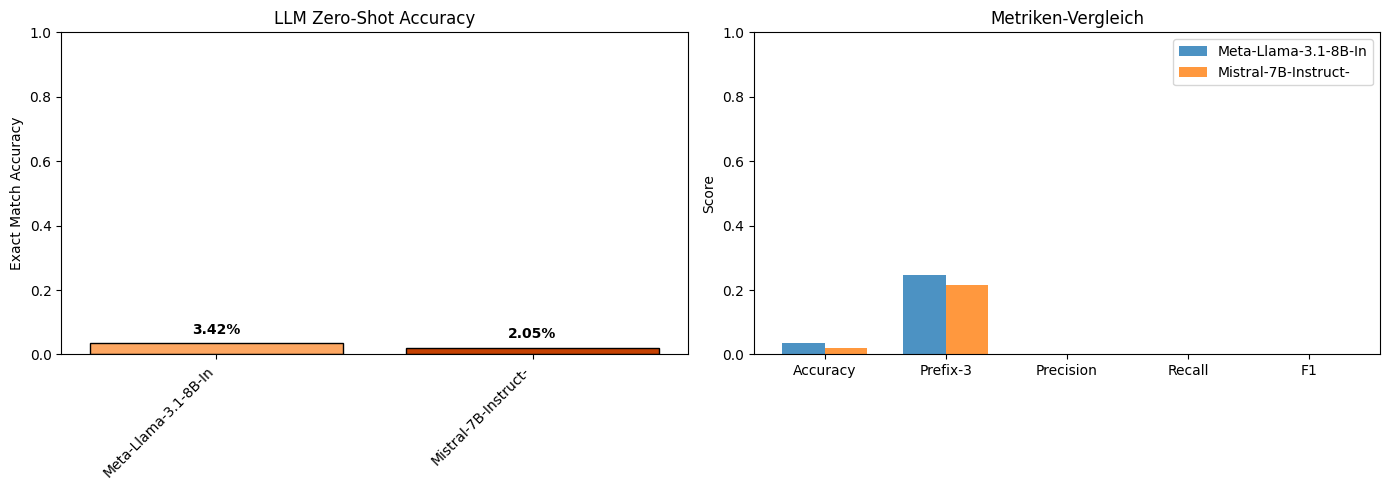

Plot gespeichert: /home/bmw/src/simon/finetuning/outputs/plots/llm_baseline_results.png


In [ ]:
# ============================================================
# VISUALISIERUNG
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy-Vergleich
models = list(all_results.keys())
accuracies = [all_results[m]["exact_match_accuracy"] for m in models]
short_names = [m.replace("LLM_", "").replace("_untrained", "")[:20] for m in models]

colors = plt.cm.Oranges(np.linspace(0.4, 0.8, len(models)))
bars = axes[0].bar(range(len(models)), accuracies, color=colors, edgecolor='black')
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(short_names, rotation=45, ha='right')
axes[0].set_ylabel('Exact Match Accuracy')
axes[0].set_title('LLM Zero-Shot Accuracy')
axes[0].set_ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{acc:.2%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Metriken-Vergleich
metrics_names = ['Accuracy', 'Prefix-3', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_names))
width = 0.35

for i, model in enumerate(models):
    metrics = all_results[model]
    values = [
        metrics["exact_match_accuracy"],
        metrics["prefix_match_3"],
        metrics.get("precision", 0),
        metrics.get("recall", 0),
        metrics.get("f1", 0),
    ]
    axes[1].bar(x + i*width, values, width, label=short_names[i], alpha=0.8)

axes[1].set_xticks(x + width/2)
axes[1].set_xticklabels(metrics_names)
axes[1].set_ylabel('Score')
axes[1].set_title('Metriken-Vergleich')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(config.paths.plots_dir / 'llm_baseline_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot gespeichert: {config.paths.plots_dir / 'llm_baseline_results.png'}")

## 8. Ergebnisse speichern

In [ ]:
# ============================================================
# ERGEBNISSE SPEICHERN
# ============================================================

# Als JSON
results_path = config.paths.reports_dir / "llm_baseline_results.json"
with open(results_path, 'w') as f:
    json.dump(all_results, f, indent=2, default=str)

print(f"Ergebnisse gespeichert: {results_path}")

# Zusammenfassung
summary = {
    "evaluation_type": "LLM Zero-Shot Baseline",
    "test_samples": len(test_data),
    "models_evaluated": len(all_results),
    "best_model": best_llm[0],
    "best_accuracy": best_llm[1]["exact_match_accuracy"],
    "evaluated_at": datetime.now().isoformat(),
}

summary_path = config.paths.reports_dir / "llm_baseline_summary.json"
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Zusammenfassung gespeichert: {summary_path}")

Ergebnisse gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/llm_baseline_results.json
Zusammenfassung gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/llm_baseline_summary.json


In [ ]:
# ============================================================
# FINALE ZUSAMMENFASSUNG
# ============================================================

print("=" * 60)
print("ZUSAMMENFASSUNG: LLM Zero-Shot Baseline")
print("=" * 60)
print(f"""Evaluation abgeschlossen!

Evaluierte Modelle: {len(all_results)}
""")

for model, metrics in all_results.items():
    short = model.replace("LLM_", "").replace("_untrained", "")
    print(f"   - {short}:")
    print(f"     Accuracy: {metrics['exact_match_accuracy']:.4f} ({metrics['exact_match_accuracy']*100:.2f}%)")
    print(f"     F1: {metrics.get('f1', 0):.4f}")

print(f"""
Bestes LLM: {best_llm[0].replace('LLM_', '').replace('_untrained', '')}
   Accuracy: {best_llm[1]['exact_match_accuracy']:.2%}

Interpretation:
   Diese Baseline zeigt die Zero-Shot Performance großer Modelle.
   Im nächsten Notebook trainieren wir kleinere Modelle mit LoRA,
   um zu sehen ob Spezialisierung Größe schlagen kann.

Gespeicherte Dateien:
   - {results_path}
   - {summary_path}
   - {config.paths.plots_dir / 'llm_baseline_results.png'}

Nächster Schritt: Notebook 04 - SLM Training (LoRA)
""")

ZUSAMMENFASSUNG: LLM Zero-Shot Baseline
Evaluation abgeschlossen!

Evaluierte Modelle: 2

   - Meta-Llama-3.1-8B-Instruct:
     Accuracy: 0.0342 (3.42%)
     F1: 0.0000
   - Mistral-7B-Instruct-v0.3:
     Accuracy: 0.0205 (2.05%)
     F1: 0.0000

Bestes LLM: Meta-Llama-3.1-8B-Instruct
   Accuracy: 3.42%

Interpretation:
   Diese Baseline zeigt die Zero-Shot Performance großer Modelle.
   Im nächsten Notebook trainieren wir kleinere Modelle mit LoRA,
   um zu sehen ob Spezialisierung Größe schlagen kann.

Gespeicherte Dateien:
   - /home/bmw/src/simon/finetuning/outputs/reports/llm_baseline_results.json
   - /home/bmw/src/simon/finetuning/outputs/reports/llm_baseline_summary.json
   - /home/bmw/src/simon/finetuning/outputs/plots/llm_baseline_results.png

Nächster Schritt: Notebook 04 - SLM Training (LoRA)

